#Springleaf Marketing Response

## Features Selection and models validation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import collections
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.cross_validation import cross_val_score, StratifiedKFold, KFold
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import roc_curve, auc, roc_auc_score
from scipy import interp

#Evaluation

Submissions are evaluated on area under the ROC curve between the predicted probability and the observed target.

In [2]:
x_train = np.loadtxt("Features/train1309")
y_train = np.loadtxt("Features/ytrain1309")

In [ ]:
print y_train.sum(), y_train.shape[0]

33773.0 145231


##Random Forest Model

moyenne auc (cv) =  0.754616177627


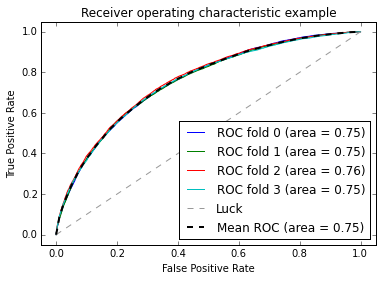

[0.75407051772167755, 0.75250227090441879, 0.75993846475643234, 0.75245116429714332] 0.75474060442


In [30]:
kfold = KFold(y_train.shape[0],3,shuffle=True)
score = []

X=np.array(x_train[:,f_sel])
y=np.array(y_train)
cv = StratifiedKFold(y, n_folds=4, shuffle=True)

classifier = RandomForestClassifier(n_estimators=100,n_jobs=8,max_depth=10)

mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
all_tpr = []
all_fpr = []
for i, (tran, tet) in enumerate(cv):
    classifier.fit(X[tran], y[tran])
    probas_ = classifier.predict_proba(X[tet])
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y[tet], probas_[:, 1])
    all_tpr.append(tpr)
    all_fpr.append(fpr)    

    
for i in range(len(all_tpr)):
    roc_auc = auc(all_fpr[i], all_tpr[i])
    score.append(roc_auc)
    mean_tpr += interp(mean_fpr, all_fpr[i], all_tpr[i])
    mean_tpr[0] = 0.0
    plt.plot(all_fpr[i], all_tpr[i], lw=1, label='ROC fold %d (area = %0.2f)' % (i, roc_auc))

plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Luck')

mean_tpr /= len(cv)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
print "moyenne auc (cv) = ", mean_auc
plt.plot(mean_fpr, mean_tpr, 'k--',
         label='Mean ROC (area = %0.2f)' % mean_auc, lw=2)

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

print score, np.mean(score)

## Features Selection using RandomForest features importance
Remove some columns by using features importance of RandomForest
fit many trees with a high max_depth and remove features with 0 importance i.e. never chosen by any trees.

In [9]:
X=np.array(x_train)
y=np.array(y_train)

classifier = RandomForestClassifier(n_estimators=500,n_jobs=8,max_depth=15)
classifier.fit(X,y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=15, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=8,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [26]:
f_imp = classifier.feature_importances_
print len(f_imp[f_imp > 1e-5])
f_sel = np.array(f_imp > 1e-5)

2167


##XGboost Model

moyenne auc (cv) =  0.778906945959


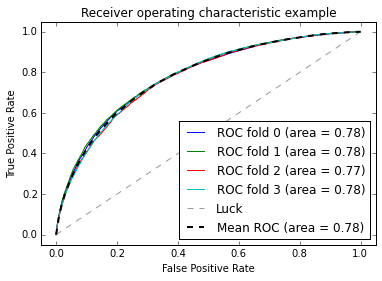

[0.78001447860161544, 0.78410789198075803, 0.7745889503267066, 0.77746456333190939] 0.77904397106


In [8]:
score = []

X=np.array(x_train)
y=np.array(y_train)

cv = StratifiedKFold(y, n_folds=4, shuffle=True)

classifier = xgb_model = xgb.XGBClassifier(colsample_bytree = 0.85, learning_rate = 0.175,
                                max_depth = 5, min_child_weight = 2, n_estimators = 150,
                                nthread = 8, objective = 'binary:logistic', seed = 1337, silent = 1, subsample = 0.85)

mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
all_tpr = []
all_fpr = []

for i, (tran, tet) in enumerate(cv):
    classifier.fit(X[tran], y[tran])
    probas_ = classifier.predict_proba(X[tet])
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y[tet], probas_[:, 1])
    all_tpr.append(tpr)
    all_fpr.append(fpr)    

    
for i in range(len(all_tpr)):
    roc_auc = auc(all_fpr[i], all_tpr[i])
    score.append(roc_auc)
    mean_tpr += interp(mean_fpr, all_fpr[i], all_tpr[i])
    mean_tpr[0] = 0.0
    plt.plot(all_fpr[i], all_tpr[i], lw=1, label='ROC fold %d (area = %0.2f)' % (i, roc_auc))

plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Luck')

mean_tpr /= len(cv)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
print "moyenne auc (cv) = ", mean_auc
plt.plot(mean_fpr, mean_tpr, 'k--',
         label='Mean ROC (area = %0.2f)' % mean_auc, lw=2)

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

print score, np.mean(score)

Parameters Search

In [ ]:
xgb_model = xgb.XGBClassifier()

parameters = {'nthread':[8], #when use hyperthread, xgboost may become slower
              'objective':['binary:logistic'],
              'learning_rate': [0.01,0.0075], #so called `eta` value
              'max_depth': [5],
              'min_child_weight': [3],
              'silent': [1],
              'subsample': [0.9],
              'colsample_bytree': [0.85],
              'n_estimators': [5000,7000], #number of trees
              'seed': [1337]}

fit_parameters = {'early_stopping_rounds': 25}

def roc(est,x,y):
    return roc_auc_score(y,est.predict_proba(x)[:,1])

clf = GridSearchCV(xgb_model, parameters, n_jobs=1, 
                   cv=StratifiedKFold(y_train, n_folds=4, shuffle=True),
                   verbose=5, refit=True, scoring = roc)

clf.fit(x_train, y_train)

best_parameters, score, _ = max(clf.grid_scores_, key=lambda x: x[1])
print('Raw AUC score:', score)
for param_name in sorted(best_parameters.keys()):
    print("%s: %r" % (param_name, best_parameters[param_name]))

In [6]:
best_parameters, score, _ = max(clf.grid_scores_, key=lambda x: x[1])
print('Raw AUC score:', score)
for param_name in sorted(best_parameters.keys()):
    print("%s: %r" % (param_name, best_parameters[param_name]))

('Raw AUC score:', 0.78773021434375545)
colsample_bytree: 0.85
learning_rate: 0.02
max_depth: 5
min_child_weight: 3
n_estimators: 2000
nthread: 8
objective: 'binary:logistic'
seed: 1337
silent: 1
subsample: 0.9


In [4]:
xgb_model = xgb.XGBClassifier(colsample_bytree = 0.75, learning_rate = 0.2,
                                max_depth = 5, min_child_weight = 3, n_estimators = 100,
                                nthread = 8, objective = 'binary:logistic', seed = 1337, silent = 1, subsample = 0.8)
xgb_model.fit(x_train,y_train)

XGBClassifier(base_score=0.5, colsample_bytree=0.75, gamma=0,
       learning_rate=0.2, max_delta_step=0, max_depth=5,
       min_child_weight=3, missing=None, n_estimators=100, nthread=8,
       objective='binary:logistic', seed=1337, silent=1, subsample=0.8)

In [ ]:
X=np.array(x_train)
y=np.array(y_train)

cv = StratifiedKFold(y, n_folds=4, shuffle=True)

class1 = RandomForestClassifier(n_estimators=100,n_jobs=8,max_depth=4,min_samples_split=1,class_weight={0:1,1:3})
classifier = AdaBoostClassifier(class1,n_estimators=100,learning_rate=0.75)

all_tpr = []
all_fpr = []

for i, (tran, tet) in enumerate(cv):
    probas_ = classifier.fit(X[tran], y[tran]).predict_proba(X[tet])
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y[tet], probas_[:, 1])
    all_tpr.append(tpr)
    all_fpr.append(fpr)

moyenne auc (cv) =  0.784579985892


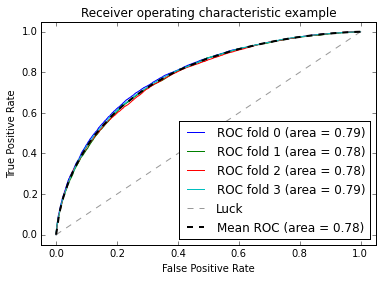

[0.78956501762107911, 0.78231035963632289, 0.78121863519834367, 0.78589922426211278, 0.78956501762107911, 0.78231035963632289, 0.78121863519834367, 0.78589922426211278, 0.78956501762107911, 0.78231035963632289, 0.78121863519834367, 0.78589922426211278] 0.784748309179


In [33]:
score = []

mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)

for i in range(len(all_tpr)):
    roc_auc = auc(all_fpr[i], all_tpr[i])
    score.append(roc_auc)
    mean_tpr += interp(mean_fpr, all_fpr[i], all_tpr[i])
    mean_tpr[0] = 0.0
    plt.plot(all_fpr[i], all_tpr[i], lw=1, label='ROC fold %d (area = %0.2f)' % (i, roc_auc))

plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Luck')

mean_tpr /= len(cv)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
print "moyenne auc (cv) = ", mean_auc
plt.plot(mean_fpr, mean_tpr, 'k--',
         label='Mean ROC (area = %0.2f)' % mean_auc, lw=2)

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

print score, np.mean(score)